<a href="https://colab.research.google.com/github/alexre24/Stroke-Prediction-Modeling/blob/main/Stroke_Prediction_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stroke Prediction Modeling
#### In this project, I have created and tuned multiple models to predict if a patient will or will not have a stroke based on characteristics of the patient. 

## Import Libraries

In [75]:
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd 
import numpy as np
import sys
from sklearn.model_selection import train_test_split, GridSearchCV 

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

#Classification Libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

import scipy.stats as stats

## Loading Data

In [2]:
path = 'healthcare-dataset-stroke-data 2.csv'
stroke_df = pd.read_csv(path)
stroke_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## Data Cleaning

In [3]:
#This dataset is very imbalanced
stroke_df['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

In [4]:
stroke_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


- There are 12 columns and 5110 rows
- The bmi column is missing data, which will have to be dealt with using Simple Imputer

In [5]:
#Dropping unnecessary columns
stroke_df = stroke_df.drop(columns = 'id')

In [6]:
#Checking for missing values
print(f'There are {stroke_df.isna().sum().sum()} missing values.')

There are 201 missing values.


In [7]:
# Getting the balance of data for the target values
stroke_df['stroke'].value_counts(normalize = True)

0    0.951272
1    0.048728
Name: stroke, dtype: float64

- This data is extremely unbalanced- 95% of data points are in the 0 class

In [8]:
#Check for duplicates
print(f'There are {stroke_df.duplicated().sum()} duplicates.')

There are 0 duplicates.


In [9]:
#Check the data types of each column
stroke_df.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [10]:
#Check for inconsistent values
stroke_df['gender'].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [11]:
#Drop the "Other" column, as there is only one row here
stroke_df.drop(stroke_df[(stroke_df['gender'] == 'Other')].index, inplace=True)
stroke_df['gender'].value_counts()

Female    2994
Male      2115
Name: gender, dtype: int64

In [12]:
stroke_df['ever_married'].value_counts()

Yes    3353
No     1756
Name: ever_married, dtype: int64

In [13]:
stroke_df['Residence_type'].value_counts()

Urban    2596
Rural    2513
Name: Residence_type, dtype: int64

In [14]:
stroke_df['smoking_status'].value_counts()

never smoked       1892
Unknown            1544
formerly smoked     884
smokes              789
Name: smoking_status, dtype: int64

In [15]:
stroke_df['work_type'].value_counts()

Private          2924
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

In [16]:
#Drop the "Never_worked" column, as there is only one row here
stroke_df.drop(stroke_df[(stroke_df['work_type'] == 'Never_worked')].index, inplace=True)
stroke_df['work_type'].value_counts()

Private          2924
Self-employed     819
children          687
Govt_job          657
Name: work_type, dtype: int64

In [17]:
#Checking for impossible values
stroke_df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5087.000000,5087.000000,5087.000000,5087.000000,4886.000000,5087.000000
mean,43.346963,0.097897,0.054256,106.184069,28.909640,0.048948
std,22.591698,0.297204,0.226544,45.340478,7.853621,0.215781
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,26.000000,0.000000,0.000000,77.235000,23.600000,0.000000
50%,45.000000,0.000000,0.000000,91.890000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


## Feature Engineering

In [18]:
#After researching, I found that anyone with a glucose level over 140 has high levels
#I decided to add this as an extra feature
stroke_df['high_or_low_glucose'] = stroke_df['avg_glucose_level'].apply(lambda x: 'High' if x > 140 else 'Normal')
stroke_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,high_or_low_glucose
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,High
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1,High
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,Normal
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,High
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,High


In [19]:
#I can do something similar with the bmi column
#A high bmi is over 25
stroke_df['high_bmi'] = stroke_df['bmi'].apply(lambda x: 'High' if x > 25 else 'Normal')
stroke_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,high_or_low_glucose,high_bmi
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,High,High
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1,High,Normal
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,Normal,High
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,High,High
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,High,Normal


## Exploratory Visuals

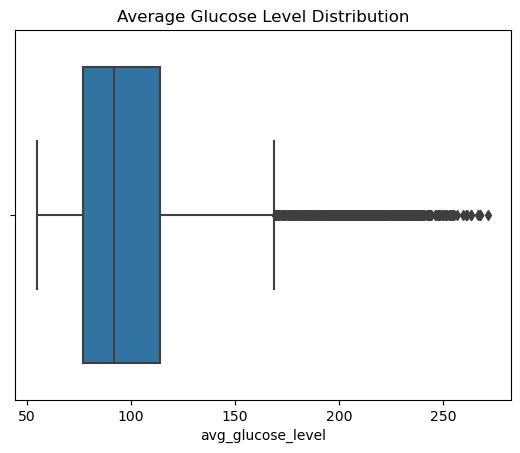

In [20]:
sns.boxplot(data = stroke_df, x = 'avg_glucose_level').set(title = 'Average Glucose Level Distribution');

- This is a boxplot showing the distribution of the average glucose level of patients. The median is about 75. There are outliers in this column that need to be removed.  


In [21]:
#Check for outliers
print(np.where(stroke_df['avg_glucose_level']>170))

(array([   0,    1,    3,    4,    5,   13,   14,   16,   17,   19,   20,
         21,   22,   23,   27,   28,   29,   30,   32,   33,   36,   44,
         45,   54,   55,   57,   58,   59,   60,   66,   71,   73,   76,
         90,   95,   97,  101,  102,  107,  113,  115,  122,  123,  124,
        128,  130,  132,  134,  135,  137,  138,  139,  144,  149,  151,
        155,  157,  158,  163,  175,  179,  187,  189,  190,  193,  195,
        196,  201,  212,  215,  217,  218,  219,  220,  222,  225,  226,
        233,  234,  235,  241,  242,  243,  253,  255,  257,  271,  276,
        277,  292,  297,  302,  306,  313,  317,  324,  325,  329,  330,
        331,  336,  342,  349,  354,  359,  364,  385,  395,  398,  410,
        416,  425,  428,  432,  435,  443,  455,  465,  466,  467,  476,
        478,  491,  514,  543,  548,  550,  551,  558,  562,  569,  575,
        580,  582,  584,  594,  597,  598,  608,  614,  618,  640,  704,
        706,  717,  742,  744,  753,  760,  768,  

In [22]:
#Drop rows with outliers
stroke_df.drop([0,    1,    3,    4,    5,   13,   14,   16,   17,   19,   20,
         21,   22,   23,   27,   28,   29,   30,   32,   33,   36,   44,
         45,   54,   55,   57,   58,   59,   60,   66,   71,   73,   76,
         90,   95,   97,  101,  102,  107,  113,  115,  122,  123,  124,
        128,  130,  132,  134,  135,  137,  138,  139,  144,  149,  151,
        155,  157,  158,  163,  175,  179,  187,  189,  190,  193,  195,
        196,  201,  212,  215,  217,  218,  219,  220,  222,  225,  226,
        233,  234,  235,  241,  242,  243,  254,  256,  258,  272,  277,
        278,  293,  298,  303,  307,  314,  318,  325,  326,  330,  331,
        332,  337,  343,  350,  355,  360,  365,  386,  396,  399,  411,
        417,  426,  429,  433,  436,  444,  456,  466,  467,  468,  477,
        479,  492,  515,  544,  549,  551,  552,  559,  563,  570,  576,
        581,  583,  585,  595,  598,  599,  610,  616,  620,  642,  706,
        708,  719,  744,  746,  755,  762,  770,  785,  816,  846,  848,
        851,  865,  867,  880,  887,  894,  923,  929,  930,  946,  948,
        970,  971, 1011, 1059, 1061, 1067, 1070, 1071, 1092, 1097, 1102,
       1104, 1113, 1118, 1131, 1158, 1166, 1173, 1178, 1187, 1189, 1200,
       1202, 1207, 1214, 1225, 1228, 1233, 1245, 1250, 1257, 1277, 1282,
       1300, 1309, 1319, 1322, 1339, 1343, 1346, 1379, 1382, 1384, 1398,
       1411, 1412, 1414, 1436, 1453, 1457, 1468, 1472, 1474, 1485, 1487,
       1497, 1503, 1512, 1526, 1529, 1531, 1533, 1534, 1535, 1540, 1547,
       1553, 1588, 1596, 1598, 1607, 1626, 1627, 1628, 1650, 1654, 1655,
       1659, 1667, 1675, 1681, 1698, 1704, 1711, 1718, 1723, 1732, 1737,
       1756, 1759, 1769, 1778, 1780, 1782, 1795, 1798, 1816, 1820, 1827,
       1837, 1840, 1841, 1843, 1853, 1862, 1873, 1880, 1888, 1889, 1892,
       1893, 1898, 1905, 1952, 1971, 1981, 1995, 2004, 2018, 2044, 2059,
       2067, 2069, 2079, 2081, 2089, 2096, 2102, 2107, 2124, 2126, 2129,
       2132, 2135, 2149, 2158, 2161, 2168, 2169, 2180, 2182, 2185, 2200,
       2201, 2203, 2223, 2228, 2240, 2255, 2257, 2273, 2282, 2284, 2290,
       2291, 2292, 2293, 2294, 2303, 2307, 2318, 2332, 2336, 2338, 2365,
       2374, 2383, 2395, 2418, 2429, 2439, 2453, 2455, 2459, 2462, 2469,
       2486, 2493, 2494, 2515, 2520, 2523, 2532, 2540, 2544, 2548, 2553,
       2565, 2569, 2578, 2583, 2599, 2600, 2609, 2612, 2624, 2629, 2633,
       2641, 2661, 2675, 2676, 2679, 2682, 2685, 2686, 2690, 2693, 2697,
       2699, 2707, 2710, 2734, 2751, 2752, 2757, 2768, 2846, 2848, 2849,
       2855, 2866, 2867, 2880, 2890, 2893, 2918, 2928, 2934, 2947, 2957,
       2960, 2966, 2981, 2992, 2997, 3005, 3008, 3014, 3017, 3054, 3060,
       3069, 3074, 3088, 3130, 3146, 3148, 3150, 3152, 3157, 3161, 3186,
       3197, 3198, 3215, 3221, 3234, 3238, 3243, 3252, 3306, 3318, 3327,
       3342, 3350, 3360, 3375, 3376, 3378, 3381, 3387, 3391, 3393, 3406,
       3425, 3427, 3439, 3455, 3461, 3462, 3478, 3480, 3489, 3500, 3507,
       3510, 3517, 3522, 3536, 3537, 3548, 3564, 3578, 3587, 3594, 3599,
       3600, 3606, 3625, 3627, 3630, 3637, 3643, 3658, 3674, 3686, 3688,
       3699, 3700, 3718, 3734, 3753, 3756, 3771, 3772, 3779, 3780, 3781,
       3788, 3802, 3833, 3882, 3889, 3892, 3905, 3909, 3913, 3925, 3931,
       3943, 3956, 3959, 3962, 3964, 3965, 3980, 3982, 3994, 4008, 4022,
       4028, 4037, 4046, 4048, 4051, 4054, 4096, 4104, 4123, 4129, 4132,
       4164, 4176, 4201, 4207, 4240, 4249, 4261, 4274, 4283, 4286, 4290,
       4291, 4304, 4311, 4321, 4324, 4325, 4327, 4329, 4335, 4339, 4344,
       4356, 4360, 4366, 4376, 4377, 4390, 4434, 4437, 4446, 4447, 4453,
       4457, 4470, 4475, 4497, 4500, 4504, 4505, 4507, 4514, 4515, 4530,
       4539, 4560, 4577, 4578, 4582, 4588, 4589, 4598, 4616, 4625, 4627,
       4628, 4636, 4654, 4665, 4684, 4696, 4702, 4708, 4711, 4724, 4737,
       4738, 4739, 4740, 4750, 4763, 4809, 4816, 4823, 4836, 4855, 4861,
       4869, 4883, 4895, 4899, 4909, 4921, 4925, 4941, 4952, 4955, 4983,
       4984, 4986, 4987, 4995, 5001, 5006, 5019, 5029, 5034, 5035, 5041,
       5048, 5061, 5062, 5063, 5064, 5076],  inplace = True)

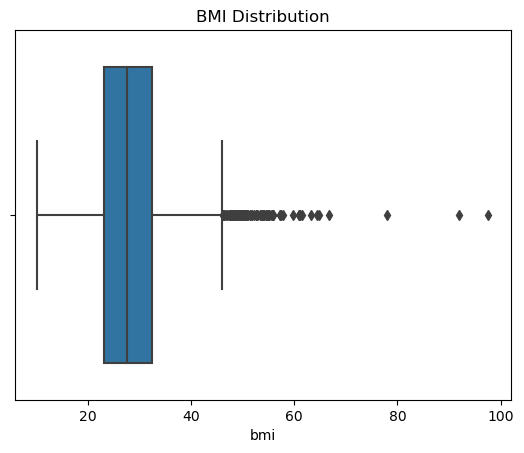

In [23]:
#Creating a box plot for bmi
sns.boxplot(data = stroke_df, x = 'bmi').set(title = 'BMI Distribution');

- This is a boxplot showing the distribution of the bmi of patients. The median is about 27. There are outliers in this column that need to be removed.

In [24]:
np.set_printoptions(threshold=sys.maxsize)

In [25]:
print(np.where(stroke_df['bmi']>44))

(array([  46,   47,  116,  183,  232,  239,  253,  261,  280,  304,  316,
        339,  344,  369,  395,  414,  479,  494,  518,  528,  569,  611,
        652,  680,  703,  764,  831,  832,  835,  843,  897,  899,  900,
       1041, 1065, 1066, 1080, 1087, 1100, 1110, 1237, 1274, 1300, 1321,
       1326, 1337, 1346, 1356, 1396, 1411, 1436, 1659, 1699, 1711, 1725,
       1775, 1824, 1829, 1890, 1912, 1942, 1953, 1966, 1976, 1996, 2035,
       2052, 2069, 2096, 2104, 2109, 2186, 2194, 2205, 2220, 2273, 2303,
       2336, 2372, 2421, 2445, 2446, 2482, 2493, 2579, 2606, 2782, 2864,
       2889, 2899, 3041, 3069, 3093, 3112, 3211, 3323, 3359, 3364, 3376,
       3411, 3511, 3541, 3593, 3619, 3649, 3650, 3669, 3683, 3685, 3737,
       3742, 3789, 3793, 3818, 3841, 3843, 3886, 3952, 3975, 3988, 4055,
       4093, 4104, 4169, 4223, 4232, 4242, 4275, 4285, 4349, 4375, 4381,
       4417, 4458]),)


In [26]:
# Dropping rows with outliers
stroke_df.drop([ 46,   47,  116,  184,  240,  262,  281,  305,  317,
        340,  345,  370,  415,  481,  496,  520,  530,  571,  613,
        654,  682,  705,  767,  836,  837,  840,  902,  904,  905,
       1046, 1085, 1105, 1115, 1242, 1280, 1306, 1327,
       1332, 1352, 1362, 1402, 1417, 1442, 1707, 1719, 1733,
       1783, 1832, 1920, 1950, 1961, 1974, 1984,
       2061, 2078, 2105, 2113, 2118, 2195, 2214, 2229, 2312,
       2433, 2457, 2458, 2505, 2592, 2619, 2797, 2879,
       2904, 2914, 3057, 3085, 3109, 3128, 3227, 3339, 3380, 3392,
       3528, 3559, 3611, 3668, 3669, 3702, 3704,
       3761, 3808, 3812, 3837, 3860, 3862, 3906, 3995, 4042,
       4076, 4114, 4125, 4191, 4246, 4255, 4265, 4298, 4308, 4372, 4398,
       4404, 4440, 4481],  inplace = True)

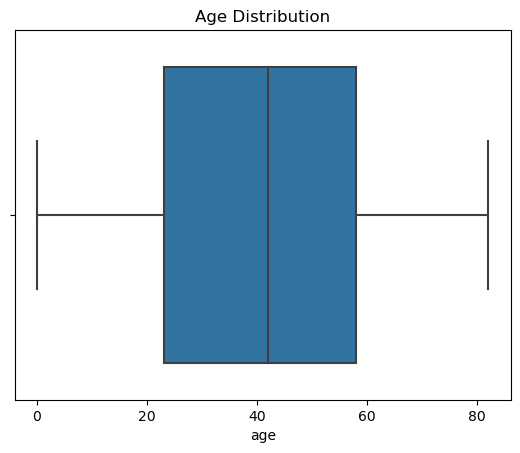

In [27]:
sns.boxplot(data = stroke_df, x = 'age').set(title = 'Age Distribution');

- This is a boxplot showing the distribution of ages of the patients in the dataset. The median age is 41

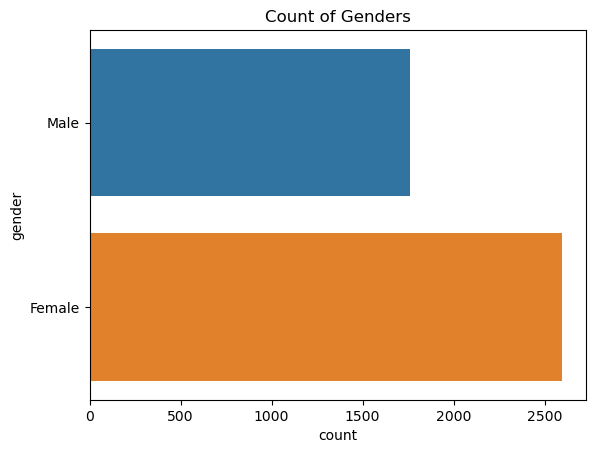

In [28]:
sns.countplot(data = stroke_df, y = 'gender').set(title = 'Count of Genders');

- This is a countplot showing the counts of each gender in the dataset. There are more females than males in the data. 

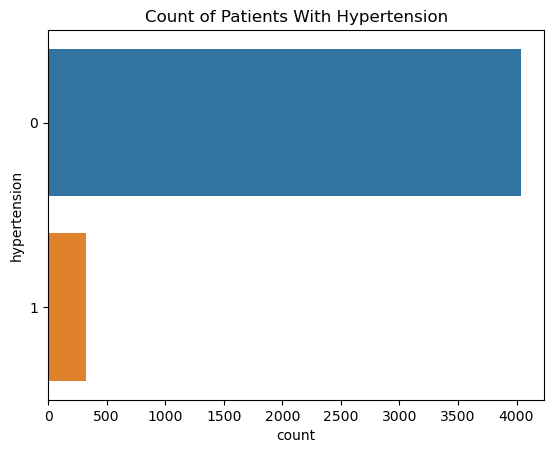

In [29]:
sns.countplot(data = stroke_df, y = 'hypertension').set(title = 'Count of Patients With Hypertension');

- This is a countplot showing the amount of patients in the dataset that have hypertension. The majority do not. 

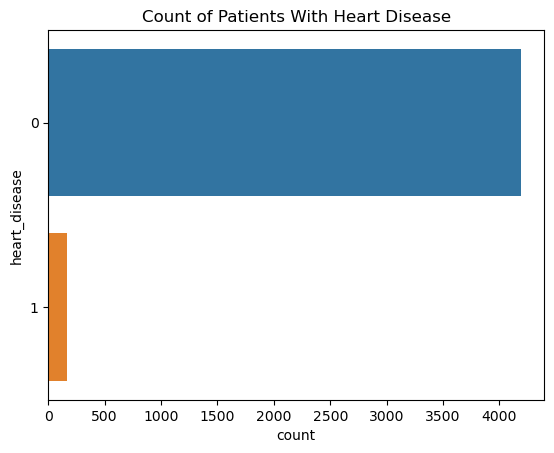

In [30]:
sns.countplot(data = stroke_df, y = 'heart_disease').set(title = 'Count of Patients With Heart Disease');

- This is a countplot showing the amount of patients in the dataset that have heart disease. The majority do not.

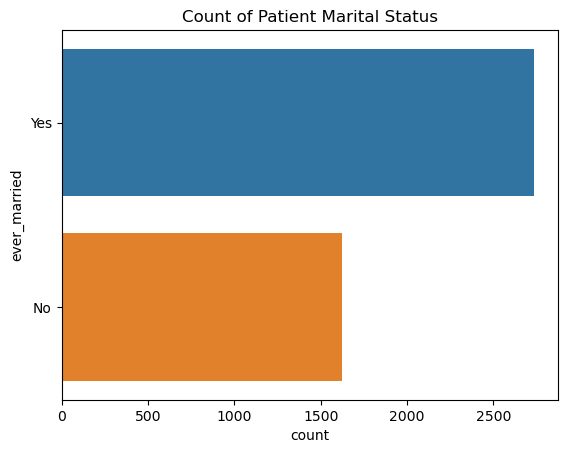

In [31]:
sns.countplot(data = stroke_df, y = 'ever_married').set(title = 'Count of Patient Marital Status');

- This is a countplot showing the amount of patients in the dataset that have been married. More have been married than have not. 

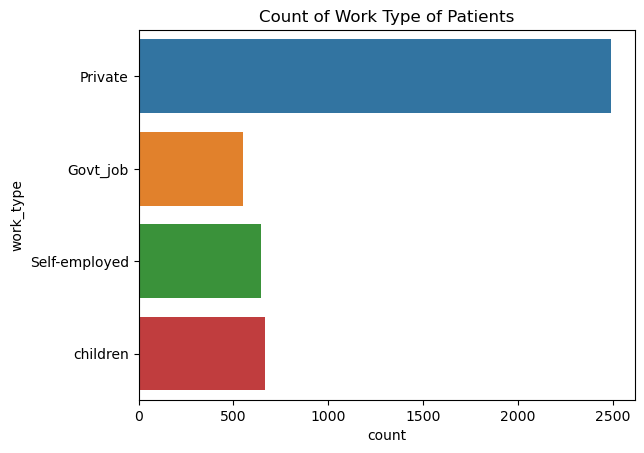

In [32]:
sns.countplot(data = stroke_df, y = 'work_type').set(title = 'Count of Work Type of Patients');

- This is a countplot showing the amount of patients in the dataset with different types of jobs. Patients most frequently work privately.

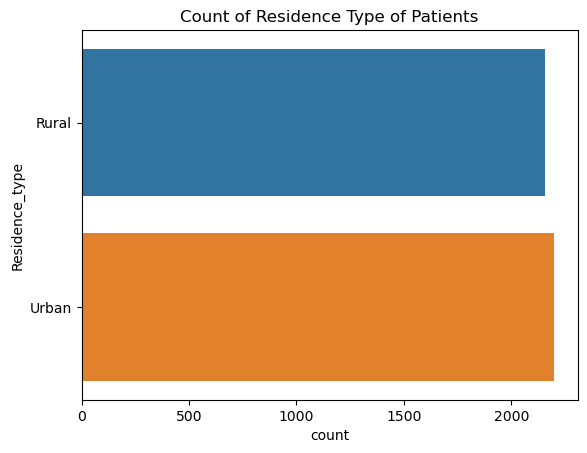

In [33]:
sns.countplot(data = stroke_df, y = 'Residence_type').set(title = 'Count of Residence Type of Patients');

- This is a countplot showing the amount of patients that live in an urban or rural area. There is an even split between both areas.

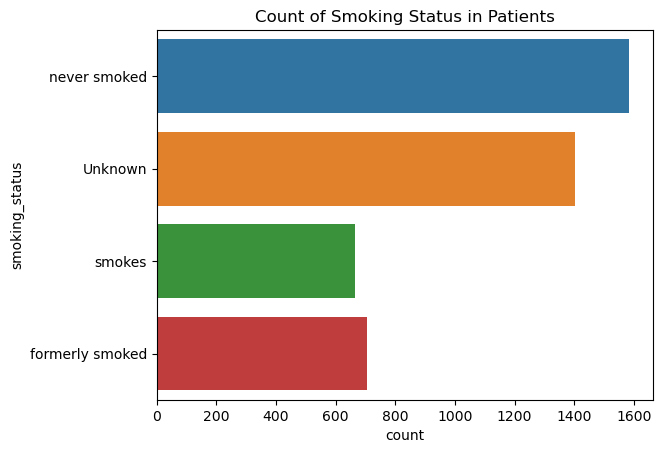

In [34]:
sns.countplot(data = stroke_df, y = 'smoking_status').set(title = 'Count of Smoking Status in Patients');

- This is a countplot showing how many patients smoke or have smoked. There is a large amount patients with an unknown status in this area.

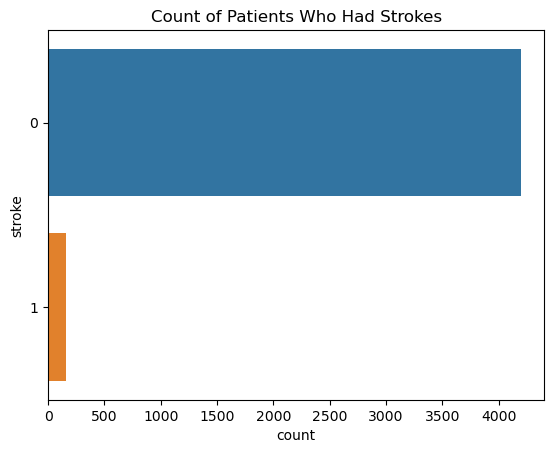

In [35]:
sns.countplot(data = stroke_df, y = 'stroke').set(title = 'Count of Patients Who Had Strokes');

- This is a countplot showing the how many patients have had a stroke. The majority of patients have not had a stroke. This is my target column. 

## Explanatory Visuals

/var/folders/f5/bdzchg655zxf5v7h5fc_qxfh0000gn/T/ipykernel_96652/3250966298.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = stroke_df.corr()


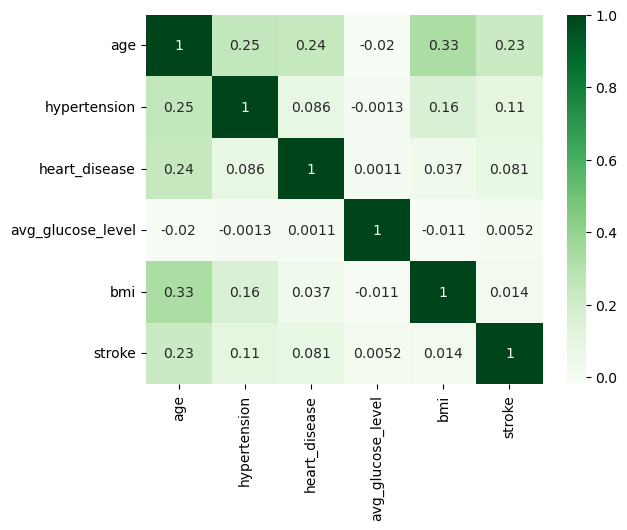

In [36]:
# Creating a heatmap to see the correlation of different features
corr = stroke_df.corr()
sns.heatmap(corr, cmap = "Greens", annot = True);

- There is a moderate positive correlation between strokes and age and hypertension. The strongest correlation in the heatmap is between age and bmi. Age and heart disease also have a moderate correlation.

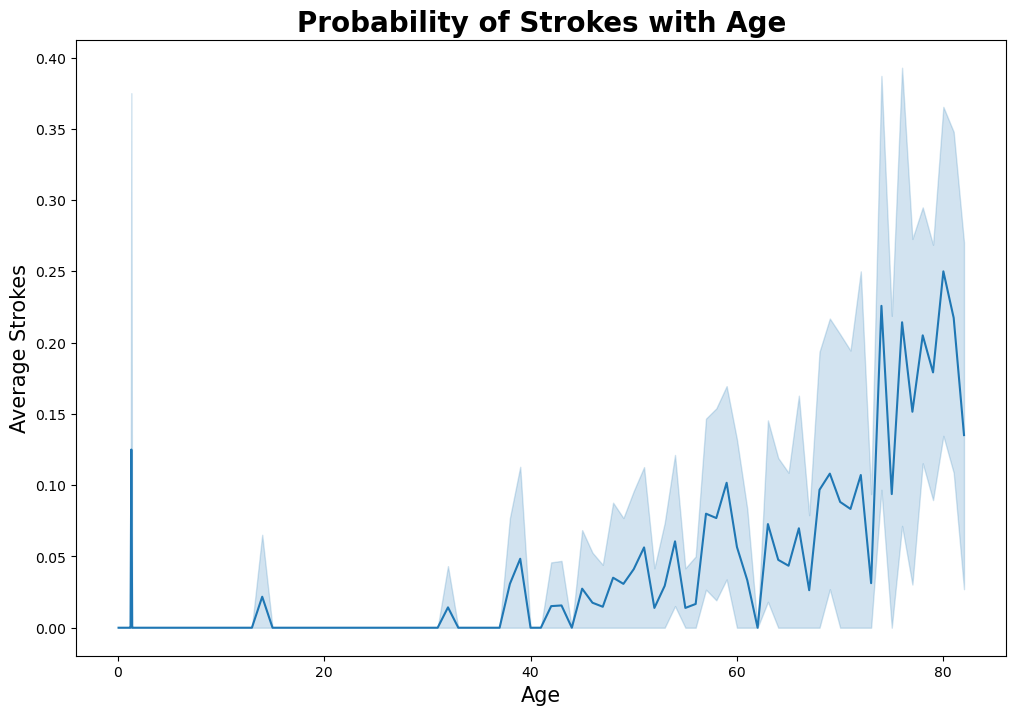

In [37]:
fig, ax = plt.subplots(figsize = (12,8))
ax = sns.lineplot(data = stroke_df, x = 'age', y = 'stroke')
ax.set_title("Probability of Strokes with Age", fontsize = 20, fontweight = "bold")
ax.set_xlabel("Age", fontsize = 15)
ax.set_ylabel("Average Strokes", fontsize = 15);

- This is a lineplot that shows the relationship between age and strokes in the patients. This shows that as age increases, the average number of strokes in patients also increases. Therefore, you are more likely to have a stroke as you get older. 

[Text(0, 0, 'No'), Text(1, 0, 'Yes')]

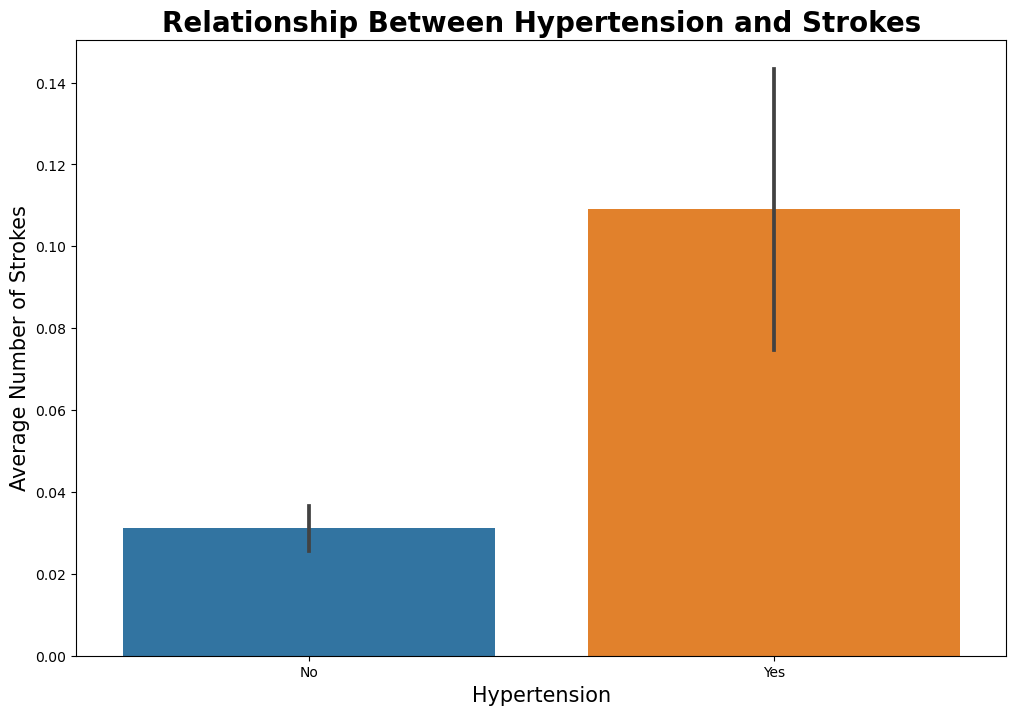

In [38]:
fig, ax = plt.subplots(figsize = (12,8))
ax = sns.barplot(data = stroke_df, x = 'hypertension', y = 'stroke')
ax.set_title("Relationship Between Hypertension and Strokes", fontsize = 20, fontweight = "bold")
ax.set_xlabel("Hypertension", fontsize = 15)
ax.set_ylabel("Average Number of Strokes", fontsize = 15);
ax.set_xticklabels(['No', 'Yes'])

- This is a barplot that shows the relationship between hypertension and strokes. The graph shows that those with hypertension are more likely to have a stroke than those that do not have hypertension. 

## Preparing Data for Modeling
- Because the data is extremely imbalanced, I am going to create a new dataframe that has all of the true positives from the original dataframe, but only 500 true negatives
- This will help to create a more reliable model


In [39]:
#Create filter for only true positives
pos_filter = stroke_df[stroke_df['stroke'] == 1]
pos_filter

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,high_or_low_glucose,high_bmi
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,Normal,High
6,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1,Normal,High
7,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1,Normal,Normal
8,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1,Normal,Normal
9,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1,Normal,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,Male,57.0,0,0,Yes,Private,Rural,84.96,36.7,Unknown,1,Normal,High
245,Female,14.0,0,0,No,children,Rural,57.93,30.9,Unknown,1,Normal,High
246,Female,75.0,0,0,Yes,Self-employed,Rural,78.80,29.3,formerly smoked,1,Normal,High
247,Male,71.0,1,0,Yes,Self-employed,Rural,87.80,NaN,Unknown,1,Normal,Normal


In [40]:
#Create filter to sample 500 true negatives
neg_filter = stroke_df[stroke_df['stroke'] == 0]
neg_filter = neg_filter.sample(n = 500)
neg_filter.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,high_or_low_glucose,high_bmi
2441,Female,65.0,0,0,Yes,Govt_job,Urban,84.47,52.7,smokes,0,Normal,High
4536,Female,68.0,1,0,Yes,Private,Urban,150.74,40.3,Unknown,0,High,High
1454,Male,62.0,0,0,Yes,Private,Rural,115.13,30.0,smokes,0,Normal,High
4776,Female,40.0,0,0,Yes,Private,Urban,65.42,17.4,formerly smoked,0,Normal,Normal
3856,Male,50.0,0,0,Yes,Self-employed,Urban,101.85,25.1,smokes,0,Normal,High


In [41]:
#Combine filters into one dataframe
frames = [neg_filter, pos_filter]
stroke_df = pd.concat(frames)
stroke_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 661 entries, 2441 to 248
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               661 non-null    object 
 1   age                  661 non-null    float64
 2   hypertension         661 non-null    int64  
 3   heart_disease        661 non-null    int64  
 4   ever_married         661 non-null    object 
 5   work_type            661 non-null    object 
 6   Residence_type       661 non-null    object 
 7   avg_glucose_level    661 non-null    float64
 8   bmi                  621 non-null    float64
 9   smoking_status       661 non-null    object 
 10  stroke               661 non-null    int64  
 11  high_or_low_glucose  661 non-null    object 
 12  high_bmi             661 non-null    object 
dtypes: float64(3), int64(3), object(7)
memory usage: 72.3+ KB


In [42]:
# Identify features and target
X = stroke_df.drop(columns = "stroke").copy()
y = stroke_df["stroke"].copy()

# Train, test, split- stratify so train and test values have same proportions
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y , random_state=42)

In [43]:
# Using Simple Imputer to fill in missing columns for the bmi column with the mean
mean_imputer = SimpleImputer(strategy = 'mean')

In [44]:
#Instantiate StandardScaler and OneHotEncoder
scaler = StandardScaler()
ohe = OneHotEncoder(sparse = False, handle_unknown='ignore')

In [45]:
#Make column selector for missing values
nominal_cols = make_column_selector(dtype_include = 'object')
num_selector = make_column_selector(dtype_include = 'number')

In [46]:
#Make Pipelines- Scaler for numeric values and OneHotEncoder for nominal values
num_pipeline = make_pipeline(mean_imputer, scaler)
nom_pipeline = make_pipeline(ohe)

In [47]:
#Make Tuples
numeric_tuple = (num_pipeline, num_selector)
nominal_tuple = (nom_pipeline, nominal_cols)

In [48]:
#Make Preprocessor
preprocessor = make_column_transformer(numeric_tuple,
                                       nominal_tuple, remainder = 'passthrough')

## KNN Model


In [49]:
#Instantiate KNN
knn = KNeighborsClassifier()

knn_pipe = make_pipeline(preprocessor, knn)

knn_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x144f1d640>),
                                   ('pipeline-2',
                                    Pipeline(steps=[('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse=False))]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x144f29400>)])),
  ('kneighborsclassifier', KNe

In [50]:
#Identify hyperparameters to tune
knn_param_grid = {'kneighborsclassifier__n_neighbors': range(1,10),
                  'kneighborsclassifier__p': range(1,5),
                  'kneighborsclassifier__weights': ['distance','uniform']}

In [51]:
#Filter out warnings
import warnings
warnings.filterwarnings('ignore')

#Tune hyperparameters using GridSearchCV
knn_pipe_gs = GridSearchCV(knn_pipe, knn_param_grid)

knn_pipe_gs.fit(X_train, y_train)
print('Best KNN Parameters:')
print(knn_pipe_gs.best_params_)
best_pipe = knn_pipe_gs.best_estimator_
print(f'Accuracy of best KNN model is: {best_pipe.score(X_test, y_test)}')

Best KNN Parameters:
{'kneighborsclassifier__n_neighbors': 7, 'kneighborsclassifier__p': 4, 'kneighborsclassifier__weights': 'uniform'}
Accuracy of best KNN model is: 0.7469879518072289


In [52]:
# Create an instance of the best model
knn = KNeighborsClassifier(n_neighbors= 7, p = 3)
# Create a model pipeline
tuned_knn_pipe = make_pipeline(preprocessor, knn)
# Fit on train data
tuned_knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x144f1d640>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x144f29400>)])),
                ('kneighborsclassifier',
                 KNeighborsClassifier(n_neighbors=7, p=3))])

In [53]:
# Save the model's predictions for the test dataset
knn_train_predictions = tuned_knn_pipe.predict(X_train)

              precision    recall  f1-score   support

           0       0.85      0.98      0.91       374
           1       0.87      0.45      0.60       121

    accuracy                           0.85       495
   macro avg       0.86      0.72      0.75       495
weighted avg       0.85      0.85      0.83       495



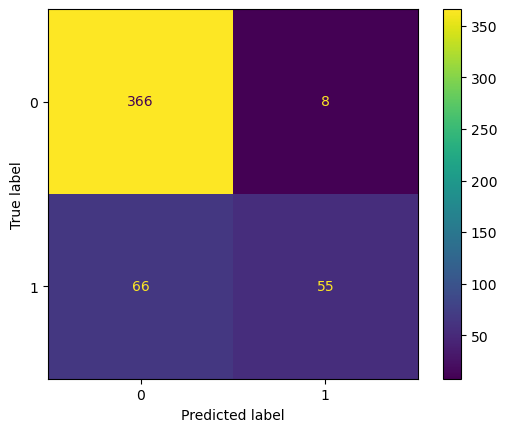

In [54]:
#Create a confusion matrix and get metrics
ConfusionMatrixDisplay.from_predictions(y_train, knn_train_predictions);
print(classification_report(y_train, knn_train_predictions))

In [55]:
# Save the model's predictions for the test dataset
knn_test_predictions = tuned_knn_pipe.predict(X_test)

              precision    recall  f1-score   support

           0       0.79      0.92      0.85       126
           1       0.50      0.25      0.33        40

    accuracy                           0.76       166
   macro avg       0.65      0.59      0.59       166
weighted avg       0.72      0.76      0.73       166



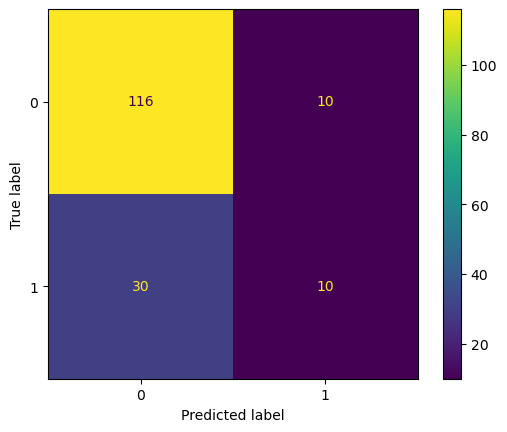

In [56]:
#Create a confusion matrix and get metrics
ConfusionMatrixDisplay.from_predictions(y_test, knn_test_predictions);
print(classification_report(y_test, knn_test_predictions))

## DecisionTree Model

In [57]:
dectree = DecisionTreeClassifier(random_state = 42)

dectree_pipe = make_pipeline(preprocessor, dectree)

dectree_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x144f1d640>),
                                   ('pipeline-2',
                                    Pipeline(steps=[('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse=False))]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x144f29400>)])),
  ('decisiontreeclassifier', D

In [58]:
#Identify hyperparameters to tune
dectree_param_grid = {'decisiontreeclassifier__max_depth': range(1,10),
                      'decisiontreeclassifier__min_samples_leaf': range(1,5),
                      'decisiontreeclassifier__min_samples_split': range(1,10)}

In [59]:
#Filter out warnings
import warnings
warnings.filterwarnings('ignore')

#Tune hyperparameters using GridSearchCV
dectree_pipe_gs = GridSearchCV(dectree_pipe, dectree_param_grid)

dectree_pipe_gs.fit(X_train, y_train)
print('Best Decision Tree Parameters:')
print(dectree_pipe_gs.best_params_)
best_pipe = dectree_pipe_gs.best_estimator_
print(f'Accuracy of best Decision Tree model is: {best_pipe.score(X_test, y_test)}')

Best Decision Tree Parameters:
{'decisiontreeclassifier__max_depth': 2, 'decisiontreeclassifier__min_samples_leaf': 1, 'decisiontreeclassifier__min_samples_split': 2}
Accuracy of best Decision Tree model is: 0.7951807228915663


In [60]:
# Create an instance of the best model 
dectree = DecisionTreeClassifier(max_depth = 3, min_samples_leaf= 1, min_samples_split= 2)
# Create a model pipeline
tuned_dectree_pipe = make_pipeline(preprocessor, dectree)
# Fit on train data
tuned_dectree_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x144f1d640>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x144f29400>)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=3))])

In [61]:
# Save the model's predictions for the train dataset
dectree_train_predictions = tuned_dectree_pipe.predict(X_train)

              precision    recall  f1-score   support

           0       0.83      0.97      0.89       374
           1       0.79      0.38      0.51       121

    accuracy                           0.82       495
   macro avg       0.81      0.67      0.70       495
weighted avg       0.82      0.82      0.80       495



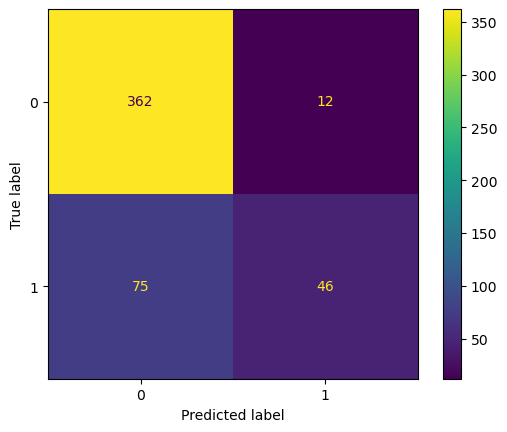

In [62]:
#Create a confusion matrix and get metrics
ConfusionMatrixDisplay.from_predictions(y_train, dectree_train_predictions);
print(classification_report(y_train, dectree_train_predictions))

In [63]:
# Save the model's predictions for the test dataset
dectree_test_predictions = tuned_dectree_pipe.predict(X_test)

              precision    recall  f1-score   support

           0       0.81      0.95      0.88       126
           1       0.67      0.30      0.41        40

    accuracy                           0.80       166
   macro avg       0.74      0.63      0.64       166
weighted avg       0.78      0.80      0.76       166



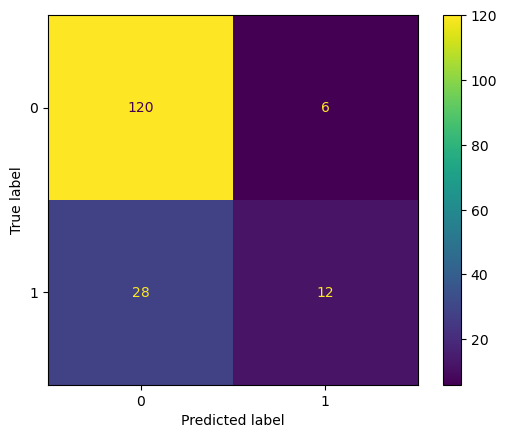

In [64]:
#Create a confusion matrix and get metrics
ConfusionMatrixDisplay.from_predictions(y_test, dectree_test_predictions);
print(classification_report(y_test, dectree_test_predictions))

- Both the KNN model and the Decision Tree model did not perform very well on the test data. The KNN model had a 75% accuracy and the Decision Tree model had an 80% accuracy, but they both did worse when trying to predict a true positive. This could be a matter of life or death for someone, because they could be at risk for a stroke, but be told by this model that they are not. I would choose the decision tree model to move forward with, as it did correctly predict more true positives on the test data, and had a higher overall accuracy. The model did not perform well because the data was extremely imbalanced.

## Hypothesis Testing: Does your sex impact the chances of having a stroke?
- Null hypothesis: There is no significant difference in the chance of having a stroke between males and females.
- Alternative hypothesis: There is a significant difference in the chance of having a stroke between males and females.

In [65]:
stroke_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 661 entries, 2441 to 248
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               661 non-null    object 
 1   age                  661 non-null    float64
 2   hypertension         661 non-null    int64  
 3   heart_disease        661 non-null    int64  
 4   ever_married         661 non-null    object 
 5   work_type            661 non-null    object 
 6   Residence_type       661 non-null    object 
 7   avg_glucose_level    661 non-null    float64
 8   bmi                  621 non-null    float64
 9   smoking_status       661 non-null    object 
 10  stroke               661 non-null    int64  
 11  high_or_low_glucose  661 non-null    object 
 12  high_bmi             661 non-null    object 
dtypes: float64(3), int64(3), object(7)
memory usage: 72.3+ KB


In [66]:
stroke_df['stroke'].value_counts()

0    500
1    161
Name: stroke, dtype: int64

In [69]:
stroke_df['stroke'] = stroke_df['stroke'].replace( 0 , 'No')
stroke_df['stroke'] = stroke_df['stroke'].replace( 1 , 'Yes')

In [70]:
stroke_df['stroke'].value_counts()

No     500
Yes    161
Name: stroke, dtype: int64

In [78]:
stroke_df['gender'].value_counts()

Female    378
Male      283
Name: gender, dtype: int64

### Chi-Square Test

In [79]:
# calculate the contingency table with pd.cross-tab
table = pd.crosstab(stroke_df['gender'], stroke_df['stroke'])
table

stroke,No,Yes
gender,,
Female,281,97
Male,219,64


In [80]:
# Run the Test and Save the Output
result = stats.chi2_contingency(table)
chi2, p, deg_free, expected_vals = result

In [81]:
# Print p-value
print(p)
p<.05

0.41716399641299784


False

- I accept the null hypothesis because p > 0.05
- This means that there is no significant difference between males and females when it comes to having a stroke based on this dataset

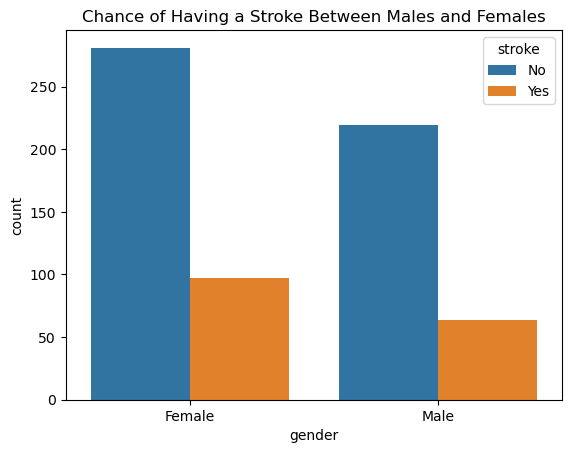

In [84]:
ax = sns.countplot(data=stroke_df, x='gender',hue='stroke',)
ax.set_title("Chance of Having a Stroke Between Males and Females");